In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm
import patsy

import numpy as np
import os
from collections import Counter
from scipy.stats.distributions import chi2
from scipy.stats import zscore

In [3]:
dblp_dir = "/hg191/corpora/semantic-progressiveness/acad-data/processed/"
dblp_features_file = os.path.join (dblp_dir, "dblp.complete")

In [4]:
df_dblp = pd.read_csv(dblp_features_file)
print (len (df_dblp))
print(df_dblp['indeg'].max())
df_dblp.head(3)

2408010
42508


,docid,indeg,outdeg,year,nauthors,nuniqs,ntokens,lang,bows,nprog,...,nprog75,nprog50,nprog25,nreg99,nreg95,nreg90,nreg75,nreg50,nreg25,ninnovs
0,35b7f3ac-25dd-4b4e-8c46-adeac09aba54,92,0,1949,2,92,152,en,11.524227,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1
1,b17b90b3-6ee1-4226-8420-b914f8fa88dc,47,1,1950,2,158,515,en,16.430503,1,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,01c6a1a9-3c59-42fa-9a27-d26cdcb9957c,0,0,1950,1,162,372,en,5.324948,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1


**Filter**

- Keep only English language records.
- Remove records that contain exactly 50 citations (I felt after plotting the histograms of the citation count that there was some discrepancy with this particular value -- better just remove it)

**Transform**
- Add an extra column for age.
- Add an extra column for not containing any semantic words.

In [5]:
print (len(df_dblp[(df_dblp["lang"] == "en") & (df_dblp["indeg"] != 50)]))
df_dblp = df_dblp[(df_dblp["lang"] == "en") & (df_dblp["indeg"] != 50)]
df_dblp = df_dblp[df_dblp["year"] >= 1955] # just so that the z-scores can be calculated (we don't miss out on much)

1671606


In [6]:
df_dblp["age"] = 2019 - df_dblp["year"]
df_dblp["isUNK"] = (df_dblp["max_prog_word"] == "UNK").astype(int)

In [7]:
# for simplicity of descriptive analysis, let's remove docs which don't hit the lexicon
# In the regression we will have to add a dummy variable to account for this.
drop_misses = True
if drop_misses:
    df_dblp = df_dblp[df_dblp["isUNK"] == 0]
print (len(df_dblp))

1159345


**Univariate analysis**

In [8]:
# quartile-ish bins of the innovation feature  
df_dblp['max_prog_q'] = pd.qcut(df_dblp['max_prog'], 4, labels=["<25", "<50", "<75", "<100"], duplicates='drop')

## Used to do this for ACL' 19
#df_dblp['nprog_q'] = pd.qcut(df_dblp['nprog'].rank(method="first"), 4, labels=["<25", "<50", "<75", "<100"], duplicates='drop')
#df_dblp['nprog25_q'] = pd.qcut(df_dblp['nprog25'].rank(method="first"), 4, labels=["<25", "<50", "<75", "<100"], duplicates="drop")
#df_dblp['nprog50_q'] = pd.qcut(df_dblp['nprog50'].rank(method="first"), 4, labels=["<25", "<50", "<75", "<100"], duplicates="drop")
#df_dblp['nprog75_q'] = pd.qcut(df_dblp['nprog75'].rank(method="first"), 4, labels=["<25", "<50", "<75", "<100"], duplicates="drop")
#df_dblp['nprog90_q'] = pd.qcut(df_dblp['nprog90'].rank(method="first"), 4, labels=["<25", "<50", "<75", "<100"], duplicates="drop")
#df_dblp['nprog95_q'] = pd.qcut(df_dblp['nprog95'].rank(method="first"), 4, labels=["<25", "<50", "<75", "<100"], duplicates="drop")
#df_dblp['nprog99_q'] = pd.qcut(df_dblp['nprog99'].rank(method="first"), 4, labels=["<25", "<50", "<75", "<100"], duplicates="drop")

In [9]:
def give_me_zscores_per_year (frame, key):
    years = frame.groupby("year").size().reset_index(name="counts")
    years = list (years[years["counts"] > 1].year.values)

    zscore_lookup = dict ()
    for year in years:
        docids = frame[frame["year"] == year]["docid"].values
        zscores = zscore (frame[frame["year"] == year][key].values)
        for i in range (len (docids)):
            zscore_lookup[docids[i]] = zscores[i]

    docids = frame["docid"].values
    zscores = [zscore_lookup[docid] for docid in docids]
    return zscores

df_dblp['max_progz'] = give_me_zscores_per_year (df_dblp, 'max_prog')
df_dblp['max_progz_q'] = pd.qcut(df_dblp['max_progz'], 4, labels=["<25", "<50", "<75", "<100"], duplicates='drop')

In [10]:
df_dblp_since_1980s = df_dblp[(df_dblp["year"] > 1980) & (df_dblp["year"] <= 2010)]
print (len(df_dblp_since_1980s))
df_dblp_since_1980s.to_csv ("../data/frames/emnlp/dblp.univariate.csv", sep=",", index=False)

549807


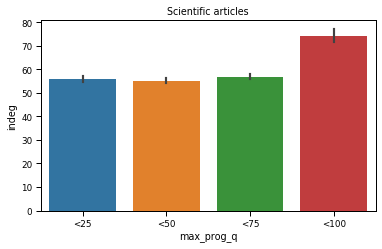

In [11]:
sns.set_context("paper")
fig,ax = plt.subplots(1,1,figsize=[6,3.5])
#sns.barplot(y='indeg',x='max_prog_q',data=df_dblp_since_1980s,ax=ax);
sns.barplot(y='indeg',x='max_prog_q',data=df_dblp_since_1980s,ax=ax);
ax.set_title('Scientific articles');

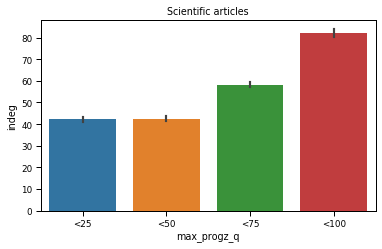

In [12]:
sns.set_context("paper")
fig,ax = plt.subplots(1,1,figsize=[6,3.5])
#sns.barplot(y='indeg',x='max_prog_q',data=df_dblp_since_1980s,ax=ax);
sns.barplot(y='indeg',x='max_progz_q',data=df_dblp_since_1980s,ax=ax);
ax.set_title('Scientific articles');

```python
# Old (for ACL'19)
sns.set_context("paper")
fig,ax = plt.subplots(1,1,figsize=[6,3.5])
sns.barplot(y='indeg',x='max_prog_q',data=df_dblp_since_1980s,ax=ax);
ax.set_title('Scientific articles');
```

```python
# Old (for ACL'19)
sns.set_context("paper")
fig,ax = plt.subplots(1,1,figsize=[6,3.5],sharey=True)

sns.barplot(y='indeg',x='nprog50_q',data=df_dblp_since_1980s,ax=ax);
ax.set_title('>50 percentile')
ax.set_xlabel('Intervals')
ax.set_ylabel('Citations')
```

**Multivariate regressions**

In [13]:
formulas_dblp = ["indeg ~ age + outdeg + nauthors + ntokens + bows + ninnovs"]
formulas_dblp.append(formulas_dblp[0]+" + max_prog")
formulas_dblp.append(formulas_dblp[0]+" + max_prog_q")
formulas_dblp.append(formulas_dblp[0]+" + max_progz")
formulas_dblp.append(formulas_dblp[0]+" + max_progz_q")
#formulas_dblp.append(formulas_dblp[0]+" + nprog50")
#formulas_dblp.append(formulas_dblp[0]+" + nprog50_q")
#formulas_dblp.append(formulas_dblp[0]+" + nprog25")
#formulas_dblp.append(formulas_dblp[0]+" + nprog25_q")
#formulas_dblp.append(formulas_dblp[0]+" + nprog75")
#formulas_dblp.append(formulas_dblp[0]+" + nprog75_q")
#formulas_dblp.append(formulas_dblp[1]+" + nprog99")
#formulas_dblp.append(formulas_dblp[1]+" + nprog99_q")

In [14]:
df_dblp_sample = df_dblp.sample (n=250000, axis=0)

In [16]:
print(len(df_dblp_sample[df_dblp_sample["max_progz_q"] == "<25"]))
print(len(df_dblp_sample[df_dblp_sample["max_progz_q"] == "<50"]))
print(len(df_dblp_sample[df_dblp_sample["max_progz_q"] == "<75"]))
print(len(df_dblp_sample[df_dblp_sample["max_progz_q"] == "<100"]))
print(len(df_dblp_sample))

62389
62401
62603
62607
250000


In [24]:
print(Counter(df_dblp_sample[df_dblp_sample["max_progz_q"] == "<25"].year.values).most_common(25))
print(Counter(df_dblp_sample[df_dblp_sample["max_progz_q"] == "<50"].year.values).most_common(25))
print(Counter(df_dblp_sample[df_dblp_sample["max_progz_q"] == "<75"].year.values).most_common(25))
print(Counter(df_dblp_sample[df_dblp_sample["max_progz_q"] == "<100"].year.values).most_common(25))

[(2016, 8580), (2015, 8146), (2013, 5380), (2014, 5200), (2012, 5036), (2011, 4095), (2010, 3656), (2009, 3052), (2008, 2568), (2007, 2391), (2017, 2196), (2006, 1956), (2005, 1730), (2004, 1399), (2003, 1074), (2002, 879), (2001, 794), (2000, 743), (1999, 553), (1998, 462), (1997, 404), (1996, 310), (1995, 273), (1994, 256), (1993, 185)]
[(2015, 6741), (2016, 6128), (2013, 5540), (2014, 5497), (2011, 5410), (2012, 5348), (2010, 4722), (2009, 4312), (2008, 3748), (2007, 2959), (2006, 2282), (2005, 1780), (2017, 1646), (2004, 1302), (2003, 898), (2002, 687), (2001, 565), (2000, 510), (1999, 380), (1998, 286), (1997, 248), (1996, 227), (1994, 188), (1995, 148), (1992, 144)]
[(2015, 4832), (2016, 4720), (2013, 3983), (2009, 3828), (2012, 3742), (2008, 3716), (2011, 3699), (2014, 3688), (2010, 3682), (2007, 3493), (2006, 3290), (2005, 2955), (2004, 2573), (2003, 2093), (2002, 1649), (2001, 1468), (2017, 1225), (2000, 1188), (1999, 1043), (1998, 842), (1997, 697), (1996, 530), (1994, 508), 

In [27]:
from scipy.stats import ks_2samp
years = range (1990, 2016)
x = [Counter(df_dblp_sample[df_dblp_sample["max_progz_q"] == "<25"].year.values)[y] for y in years]
y = [Counter(df_dblp_sample[df_dblp_sample["max_progz_q"] == "<100"].year.values)[y] for y in years]
#y = [item[1] for item in Counter(df_dblp_sample[df_dblp_sample["max_progz_q"] == "<50"].year.values).most_common(10)]
ks_2samp(x, y)

Ks_2sampResult(statistic=0.2692307692307692, pvalue=0.30712304007383906)

In [225]:
results_dblp = []
for formula in formulas_dblp:
    Y,X = patsy.dmatrices(formula,data=df_dblp_sample)
    results_dblp.append(sm.GLM(Y, X, family=sm.families.Poisson()).fit())

In [226]:
lls = [result.llf for result in results_dblp]
print(lls)
print (max(lls))

[-13058904.498834884, -13045513.011874137, -13029739.018962651, -12928727.65162692, -12816015.371621614]
-12816015.371621614


In [227]:
for i,ll_0 in enumerate(lls):
    for j,ll_1 in enumerate(lls[:i]):
        chi2_score = ll_0-ll_1
        dof = len(formulas_dblp[i].split("+")) - len(formulas_dblp[j].split('+'))
        if i == 3: dof += 2 #quartiles
        print(i,j,f'\\chi^2_{dof} = {chi2_score:.2f}, p < {chi2.sf(chi2_score, dof):.3e}')

1 0 \chi^2_1 = 13391.49, p < 0.000e+00
2 0 \chi^2_1 = 29165.48, p < 0.000e+00
2 1 \chi^2_0 = 15773.99, p < nan
3 0 \chi^2_3 = 130176.85, p < 0.000e+00
3 1 \chi^2_2 = 116785.36, p < 0.000e+00
3 2 \chi^2_2 = 101011.37, p < 0.000e+00
4 0 \chi^2_1 = 242889.13, p < 0.000e+00
4 1 \chi^2_0 = 229497.64, p < nan
4 2 \chi^2_0 = 213723.65, p < nan
4 3 \chi^2_0 = 112712.28, p < nan


In [228]:
for i in range (len (results_dblp)):
    print(results_dblp[i].summary())
    print ()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  indeg   No. Observations:               250000
Model:                            GLM   Df Residuals:                   249993
Model Family:                 Poisson   Df Model:                            6
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3059e+07
Date:                Tue, 21 May 2019   Deviance:                   2.5317e+07
Time:                        15:31:11   Pearson chi2:                 1.59e+08
No. Iterations:                    29   Covariance Type:             nonrobust
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.9429      0.001   1892.966      0.000       1.941       1.945
age            0.0793   3.17e-05   2501.715      0.0

In [230]:
df_dblp_sample.to_csv ("../data/frames/emnlp/dblp.final", sep=",", index=False)